In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from imblearn.over_sampling import RandomOverSampler
from configs.enums import RiskClassifications
import numpy as np
import os
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

2023-11-24 22:19:29.085212: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-24 22:19:30.413452: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
def split_data(dataframe: pd.DataFrame):
    data_by_risk = [dataframe[dataframe["country_risk"] == v] for v in RiskClassifications.get_values()]
    split_data = [
        # Train (60%), validation (20%) and test (20%) datasets
        np.split(sd.sample(frac=1, random_state=0), [int(0.6 * len(sd)), int(0.8 * len(sd))])
        for sd
        in data_by_risk
    ]

    train = pd.concat([row[0] for row in split_data])
    valid = pd.concat([row[1] for row in split_data])
    test = pd.concat([row[2] for row in split_data])

    return train, valid, test

In [3]:
def scale_dataset(dataframe: pd.DataFrame, oversample: bool = False):
    # if target column is the last value
    x = dataframe[dataframe.columns[:-1]].values
    y = dataframe[dataframe.columns[-1]].values

    scaler = StandardScaler()
    x = scaler.fit_transform(x)

    if oversample:
        ros = RandomOverSampler()
        x, y = ros.fit_resample(x, y)

    data = np.hstack((x, np.reshape(y, (-1, 1))))
    return data, x, y

In [4]:
df = pd.read_excel("./MachineLearning-Dataset-V1.xlsx")
train, valid, test = split_data(df)
test, x_test, test_labels = scale_dataset(test, oversample=False)

## Utility

In [5]:
def _get_last_layer_units_and_activation(num_classes):
    """Gets the # units and activation function for the last network layer.

    # Arguments
        num_classes: int, number of classes.

    # Returns
        units, activation values.
    """
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes
    return units, activation

In [6]:
def plot_history(history, num_classes):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
    ax1.plot(history["loss"], label="loss")
    ax1.plot(history["val_loss"], label="val_loss")
    ax1.set_xlabel("Epoch")
    if num_classes == 2:
        ax1.set_ylabel("Binary crossentropy")
    else:
        ax1.set_ylabel("Sparse categorical crossentropy")
    ax1.grid(True)

    ax2.plot(history["acc"], label="accuracy")
    ax2.plot(history["val_acc"], label="val_accuracy")
    ax2.set_xlabel("Epoch")
    ax2.set_ylabel("Accuracy")
    ax2.grid(True)

    plt.show()

## Deep Neural Network (DNN) 

In [7]:
from tensorflow.keras import models
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout

def dnn_model(layers, units, dropout_rate, input_shape, num_classes):
    """Creates an instance of a DNN model.

    # Arguments
        layers: int, number of `Dense` layers in the model.
        units: int, output dimension of the layers.
        dropout_rate: float, percentage of input to drop at Dropout layers.
        input_shape: tuple, shape of input to the model.
        num_classes: int, number of output classes.

    # Returns
        A DNN model instance.
    """
    op_units, op_activation = _get_last_layer_units_and_activation(num_classes)
    model = models.Sequential()
    model.add(Dropout(rate=dropout_rate, input_shape=input_shape))

    for _ in range(layers-1):
        model.add(Dense(units=units, activation="relu"))
        model.add(Dropout(rate=dropout_rate))

    model.add(Dense(units=op_units, activation=op_activation))
    return model

In [8]:
def train_dnn_model(dataframe,
                    learning_rate=1e-3,
                    epochs=1000,
                    batch_size=128,
                    layers=2,
                    units=64,
                    dropout_rate=0.2,
                    patience=2,
                    verbose=2,
                    disable_save=False,
                    disable_plot_history=False,
                    disable_print_report=False):
    """Trains DNN model on the given dataset.

    # Arguments
        dataframe: pandas dataframe containing train, test and validation data.
        learning_rate: float, learning rate for training model.
        epochs: int, number of epochs.
        batch_size: int, number of samples per batch.
        layers: int, number of `Dense` layers in the model.
        units: int, output dimension of Dense layers in the model.
        dropout_rate: float: percentage of input to drop at Dropout layers.

    # Raises
        ValueError: If validation data has label values which were not seen
            in the training data.
    """
    # Get the data.
    train, valid, test = split_data(dataframe)

    train, x_train, train_labels = scale_dataset(train, oversample=True)
    valid, x_val, val_labels = scale_dataset(valid, oversample=False)
    test, x_test, test_labels = scale_dataset(test, oversample=False)

    # Verify that validation labels are in the same range as training labels.
    num_classes = len(np.unique(dataframe[dataframe.columns[-1]].values)) + 1
    unexpected_labels = [v for v in val_labels if v not in range(num_classes)]
    if len(unexpected_labels):
        raise ValueError("Unexpected label values found in the validation set:"
                         " {unexpected_labels}. Please make sure that the "
                         "labels in the validation set are in the same range "
                         "as training labels.".format(
                             unexpected_labels=unexpected_labels))

    # Create model instance.
    model = dnn_model(layers=layers,
                      units=units,
                      dropout_rate=dropout_rate,
                      input_shape=x_train.shape[1:],
                      num_classes=num_classes)

    # Compile model with learning parameters.
    if num_classes == 2:
        loss = "binary_crossentropy"
    else:
        loss = "sparse_categorical_crossentropy"
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss=loss, metrics=["acc"])

    # Create callback for early stopping on validation loss.
    callbacks = [tf.keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=patience)]

    # Train and validate model.
    history = model.fit(
            x_train,
            train_labels,
            epochs=epochs,
            callbacks=callbacks,
            validation_data=(x_val, val_labels),
            verbose=verbose,
            batch_size=batch_size)

    # Print results.
    history = history.history
    if not disable_plot_history:
        print("Validation accuracy: {acc}, loss: {loss}".format(
                acc=history["val_acc"][-1], loss=history["val_loss"][-1]))
    
        plot_history(history, num_classes)
    
    if not disable_print_report:
        y_pred = model.predict(x_test).argmax(axis=1)
        print(classification_report(test_labels, y_pred))
    
    # Save model.
    if not disable_save:
        model.save(os.path.join(os.environ["OUTPUT_PATH"], "Risk_factor_dnn_model.keras"))
        
    return model, history["val_acc"][-1], history["val_loss"][-1]

In [9]:
def tune_dnn_model(df, layers, units, dropout_rates, learning_rates):
    least_val_loss = float('inf')
    least_val_loss_params = []
    
    i = 1 
    max = len(layers) * len(units) * len(dropout_rates) * len(learning_rates)
    for l in layers:
        for u in units:
            for dr in dropout_rates:
                for lr in learning_rates:  
                    print(f"[{i}/{max}] Layers: {l}; Units: {u}; Dropout rate: {dr}; Learning rate: {lr};")
                    
                    model, _, _ = train_dnn_model(
                        df, 
                        epochs=100, 
                        patience=20, 
                        layers=l, 
                        units=u,
                        dropout_rate=dr,
                        learning_rate=lr,
                        verbose=0,
                        disable_save=True,
                        disable_plot_history=True,
                        disable_print_report=True)
                    
                    val_loss, val_acc = model.evaluate(x_test, test_labels)
                    print(f"Loss: {val_loss}; Accuracy: {val_acc};")
                    if val_loss < least_val_loss:
                        model.save(os.path.join(os.environ["OUTPUT_PATH"], "Risk_factor_dnn_model.keras"))
                        least_val_loss = val_loss
                        least_val_loss_params = [l, u, dr, lr]
                        
                    i += 1
                        
    print(least_val_loss_params)
    print(least_val_loss)

In [ ]:
tune_dnn_model(
        df=df,
        layers=[1], # 1, 2, 3, 4, 5, 6
        units=[192, 224, 256], # 8, 16, 32, 64, 96, 128, 160, 192
        dropout_rates=[0.2], # 0.2, 0.3, 0.4, 0.5
        learning_rates=[0.001, 0.00125, 0.0015, 0.00175, 0.002], # 0.0001, 0.0005, 0.00075, 0.001, 0.00125, 0.0015, 0.00175, 0.002  
    )
   

In [10]:
model_file = "Adam_6_192_0.2_0.00175_0.1515021026134491_100.keras" # "Risk_factor_dnn_model.keras"
model = tf.keras.models.load_model(os.path.join(os.environ["OUTPUT_PATH"], model_file))

y_pred = model.predict(x_test).argmax(axis=1)
print(classification_report(test_labels, y_pred))

47/47 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           1       0.97      0.90      0.93       299
           2       0.94      0.97      0.95      1078
           3       0.75      0.71      0.73       119

    accuracy                           0.93      1496
   macro avg       0.89      0.86      0.87      1496
weighted avg       0.93      0.93      0.93      1496


## Artificial Neural Network (ANN)

In [11]:
def ann_model(units, dropout_rate, input_shape, num_classes):
    op_units, op_activation = _get_last_layer_units_and_activation(num_classes)
    
    model = models.Sequential()
    model.add(Dropout(rate=dropout_rate, input_shape=input_shape))
    model.add(Dense(units=units, activation="relu"))
    model.add(Dropout(rate=dropout_rate))
    model.add(Dense(units=op_units, activation=op_activation))
    
    return model

In [12]:
def train_ann_model(dataframe,
                    learning_rate=1e-3,
                    epochs=1000,
                    batch_size=128,
                    units=64,
                    dropout_rate=0.2,
                    patience=2,
                    verbose=2,
                    disable_save=False,
                    disable_plot_history=False,
                    disable_print_report=False):
    # Get the data.
    train, valid, test = split_data(dataframe)

    train, x_train, train_labels = scale_dataset(train, oversample=True)
    valid, x_val, val_labels = scale_dataset(valid, oversample=False)
    test, x_test, test_labels = scale_dataset(test, oversample=False)

    # Verify that validation labels are in the same range as training labels.
    num_classes = len(np.unique(dataframe[dataframe.columns[-1]].values)) + 1
    unexpected_labels = [v for v in val_labels if v not in range(num_classes)]
    if len(unexpected_labels):
        raise ValueError("Unexpected label values found in the validation set:"
                         " {unexpected_labels}. Please make sure that the "
                         "labels in the validation set are in the same range "
                         "as training labels.".format(
                             unexpected_labels=unexpected_labels))

    # Create model instance.
    model = ann_model(
                        units=units,
                        dropout_rate=dropout_rate,
                        input_shape=x_train.shape[1:],
                        num_classes=num_classes)

    # Compile model with learning parameters.
    if num_classes == 2:
        loss = "binary_crossentropy"
    else:
        loss = "sparse_categorical_crossentropy"
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss=loss, metrics=["acc"])

    # Create callback for early stopping on validation loss.
    callbacks = [tf.keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=patience)]

    # Train and validate model.
    history = model.fit(
            x_train,
            train_labels,
            epochs=epochs,
            callbacks=callbacks,
            validation_data=(x_val, val_labels),
            verbose=verbose,
            batch_size=batch_size)

    # Print results.
    history = history.history
    if not disable_plot_history:
        print("Validation accuracy: {acc}, loss: {loss}".format(
                acc=history["val_acc"][-1], loss=history["val_loss"][-1]))
    
        plot_history(history, num_classes)
        
    if not disable_print_report:
        y_pred = model.predict(x_test).argmax(axis=1)
        print(classification_report(test_labels, y_pred))
    
    # Save model.
    if not disable_save:
        model.save(os.path.join(os.environ["OUTPUT_PATH"], "Risk_factor_ann_model.keras"))
        
    return model, history["val_acc"][-1], history["val_loss"][-1]

In [13]:
def tune_ann_model(df, units, dropout_rates, learning_rates):
    least_val_loss = float('inf')
    least_val_loss_params = []
    
    i = 1 
    max = len(units) * len(dropout_rates) * len(learning_rates)
    for u in units:
        for dr in dropout_rates:
            for lr in learning_rates:  
                print(f"[{i}/{max}] Units: {u}; Dropout rate: {dr}; Learning rate: {lr};")
                
                model, _, _ = train_ann_model(
                    df, 
                    epochs=100, 
                    patience=20, 
                    units=u,
                    dropout_rate=dr,
                    learning_rate=lr,
                    verbose=0,
                    disable_save=True,
                    disable_plot_history=True,
                    disable_print_report=True)
                
                val_loss, val_acc = model.evaluate(x_test, test_labels)
                print(f"Loss: {val_loss}; Accuracy: {val_acc};")
                if val_loss < least_val_loss:
                    model.save(os.path.join(os.environ["OUTPUT_PATH"], "Risk_factor_ann_model.keras"))
                    least_val_loss = val_loss
                    least_val_loss_params = [u, dr, lr]
                    
                i += 1
                        
    print(least_val_loss_params)
    print(least_val_loss)

Epoch 1/100
76/76 - 1s - loss: 0.5705 - acc: 0.7665 - val_loss: 0.4970 - val_acc: 0.7545 - 529ms/epoch - 7ms/step
Epoch 2/100
76/76 - 0s - loss: 0.3864 - acc: 0.8318 - val_loss: 0.4280 - val_acc: 0.8080 - 190ms/epoch - 3ms/step
Epoch 3/100
76/76 - 0s - loss: 0.3596 - acc: 0.8367 - val_loss: 0.4169 - val_acc: 0.7967 - 168ms/epoch - 2ms/step
Epoch 4/100
76/76 - 0s - loss: 0.3453 - acc: 0.8440 - val_loss: 0.3520 - val_acc: 0.8515 - 150ms/epoch - 2ms/step
Epoch 5/100
76/76 - 0s - loss: 0.3457 - acc: 0.8479 - val_loss: 0.3423 - val_acc: 0.8542 - 149ms/epoch - 2ms/step
Epoch 6/100
76/76 - 0s - loss: 0.3387 - acc: 0.8483 - val_loss: 0.3073 - val_acc: 0.8803 - 142ms/epoch - 2ms/step
Epoch 7/100
76/76 - 0s - loss: 0.3380 - acc: 0.8477 - val_loss: 0.3230 - val_acc: 0.8615 - 141ms/epoch - 2ms/step
Epoch 8/100
76/76 - 0s - loss: 0.3301 - acc: 0.8490 - val_loss: 0.3180 - val_acc: 0.8749 - 163ms/epoch - 2ms/step
Epoch 9/100
76/76 - 0s - loss: 0.3302 - acc: 0.8520 - val_loss: 0.3356 - val_acc: 0.8555

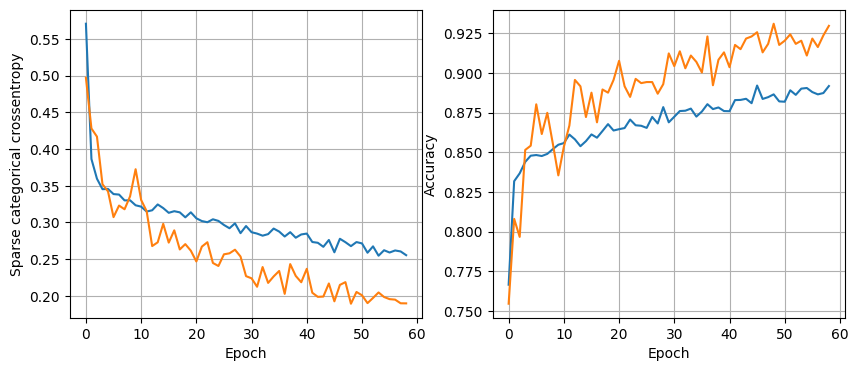

47/47 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

           1       0.93      0.93      0.93       299
           2       0.94      0.95      0.95      1078
           3       0.72      0.64      0.68       119

    accuracy                           0.92      1496
   macro avg       0.86      0.84      0.85      1496
weighted avg       0.92      0.92      0.92      1496

47/47 [==============================] - 0s 1ms/step - loss: 0.1866 - acc: 0.9238
Loss: 0.1866467297077179; Accuracy: 0.9237967729568481;


In [15]:
model, _, _ = train_ann_model(
                        df, 
                        epochs=100, 
                        patience=10, 
                        units=320,
                        dropout_rate=0.2,
                        learning_rate=0.002,
                        verbose=2,
                        disable_save=True)

val_loss, val_acc = model.evaluate(x_test, test_labels)
print(f"Loss: {val_loss}; Accuracy: {val_acc};")

In [14]:
tune_ann_model(df=df,
                units=[320],
                dropout_rates=[0.2],
                learning_rates=[0.002])

[1/1] Units: 320; Dropout rate: 0.2; Learning rate: 0.002;
47/47 [==============================] - 0s 1ms/step - loss: 0.1850 - acc: 0.9171
Loss: 0.1849970668554306; Accuracy: 0.9171122908592224;
[320, 0.2, 0.002]
0.1849970668554306
